In [1]:
import os
import os.path as osp
import json
from typing import Dict, List, Tuple, Optional
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch  # 用于连线箭头
import seaborn as sns

import numpy as np
import matplotlib
# # Use non-interactive backend if running on a server without display
# if not os.environ.get("DISPLAY"):
#     matplotlib.use("Agg")

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from datetime import datetime
from matplotlib.patches import Rectangle
import matplotlib.patheffects as pe

# Optional dependencies in your project (safe fallbacks provided)
try:
    from loguru import logger
except Exception:
    class _DummyLogger:
        def info(self, *a, **k): pass
        def warning(self, *a, **k): pass
        def error(self, *a, **k): pass
    logger = _DummyLogger()

# Project-specific utils (fallbacks if not available at runtime)
try:
    from common.utils import remove_comments, normalize_spaces, remove_spaces
except Exception:
    def remove_comments(s: str) -> str:
        return s
    def normalize_spaces(s: str) -> str:
        return " ".join(str(s).split())
    def remove_spaces(s: str) -> str:
        return str(s).replace(" ", "")
    
%matplotlib inline


In [2]:

def count_kc(d: dict) -> float:
    """
    Best-effort extraction of KC (complexity) from an item.
    Returns NaN if neither is available.
    """
    try:
        if isinstance(d.get('metainfo'), dict):
            ev = d['metainfo'].get('eval_result')
            if isinstance(ev, dict) and 'KC' in ev:
                return float(ev['KC'])
        # fallback to length of cleaned formal solution draft
        fsd = d.get('formal_solution_draft')
        if isinstance(fsd, str) and fsd.strip():
            return float(len(remove_spaces(remove_comments(fsd))))
    except Exception as e:
        logger.warning(f"count_kc fallback due to error: {e}")
    return float('nan')


def load_sample_data_from_dir(base_dir: str) -> Dict[str, List[Tuple[float, float, bool]]]:
    """
    Re-implements your mapping & pairing logic in a robust way.
    Adjust base_dir if needed (default used in main()).
    """
    NAME_MAPPING = {
        "sft_ar_v3-Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch-valid_samples.jsonl" : "DExplorer",
        "sft_ar_v3-Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913.staged-valid_samples.jsonl" : "DExplorer (Staged)",
        "sft_wg_starified-Goedel-Prover-V2-8B.Numina-Lean.whole_statement_generatior.nopack-valid_samples.jsonl" : "Conjecture-Prover",
        
        "autoformalization_pg_kimina7b-PromptCoT-DS_kimina7b-valid_samples.jsonl" : "PromptCoT-DS",
        "autoformalization_pg_kimina7b-PromptCoT-QwQ_kimina7b-valid_samples.jsonl" : "PromptCoT-QwQ",
        "autoformalization_pg_kimina7b-ScaleQuest-Math_kimina7b-valid_samples.jsonl" : "ScaleQuest-Math",
        "MUSTARDSauce_lean4_parsed-valid_samples.jsonl" : "MUSTARD",
        # "MUSTARDSauce_lean4_parsed-nocomment-valid_samples.jsonl" : "MUSTARD (w/o comment)",
    }

    eval_dir = osp.join(base_dir, "fpg_valid_fixed_evaluated")
    formal_dir = osp.join(base_dir, "fpg_valid_formal")
    sample_data: Dict[str, List[Tuple[float, float, bool]]] = {}

    if not (osp.isdir(eval_dir) and osp.isdir(formal_dir)):
        logger.warning(f"Directories not found: {eval_dir} or {formal_dir}. Returning empty dataset.")
        return sample_data

    for p in NAME_MAPPING.keys():               # 按你写的顺序
        eval_path = osp.join(eval_dir, p)
        formal_path = osp.join(formal_dir, p)
        if not (osp.exists(eval_path) and osp.exists(formal_path)):
            logger.warning(f"Missing file for {p}, skip.")
            continue
        exp_name = NAME_MAPPING[p]
        
        eval_path = osp.join(eval_dir, p)
        formal_path = osp.join(formal_dir, p)
        if not osp.exists(formal_path):
            logger.warning(f"Missing formal file for {p}, skip.")
            continue

        with open(eval_path, 'r', encoding='utf-8') as f:
            data_eval = [json.loads(l) for l in f if l.strip()]
        with open(formal_path, 'r', encoding='utf-8') as f:
            data_formal = [json.loads(l) for l in f if l.strip()]

        n = min(len(data_eval), len(data_formal))
        if n == 0:
            logger.warning(f"No paired rows for {p}.")
            continue
        data_eval, data_formal = data_eval[:n], data_formal[:n]

        rows: List[Tuple[float, float, bool]] = []
        for d, d_f in zip(data_eval, data_formal):
            kc = float(d_f.get('kc', count_kc(d_f)))
            info = d.get('informalization', {})

            if info.get('problem_type') == "Proof Question" or info.get('informal_answer_parsed') is None:
                rows.append((kc, 0.0, True))
            else:
                ev = info.get('eval_results', {})
                succeeded = len(ev.get('succeeded', []))
                failed = len(ev.get('failed', []))
                total = max(1, succeeded + failed)
                difficulty = float(np.clip(succeeded / 6, 0.0, 1.0))
                rows.append((kc, difficulty, False))
        sample_data[exp_name] = rows

    return sample_data

In [3]:
# Adjust this root if needed
base_dir = "/sfs/liuqi/data"
data = load_sample_data_from_dir(base_dir)
# plt.figure(figsize=(20, 8))

# fig, ax = visualize_data(
#     data,
#     # figsize=(20, 8),
#     dpi=120,
#     save_dir="/home/ma-user/workspace/formal_problem_generation/formal_problem_generation/figs",
#     filename_prefix="informal_results_inf",
#     save_formats=("png", "svg", "pdf"),  # save both PNG and SVG
#     show=False
# )
# # if paths:
# #     print("Saved files:", *paths, sep="\n")
# plt.show()

/tmp/ipykernel_3235182/2617138390.py:301: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.88, 1])  # 右侧预留 4% 给色条


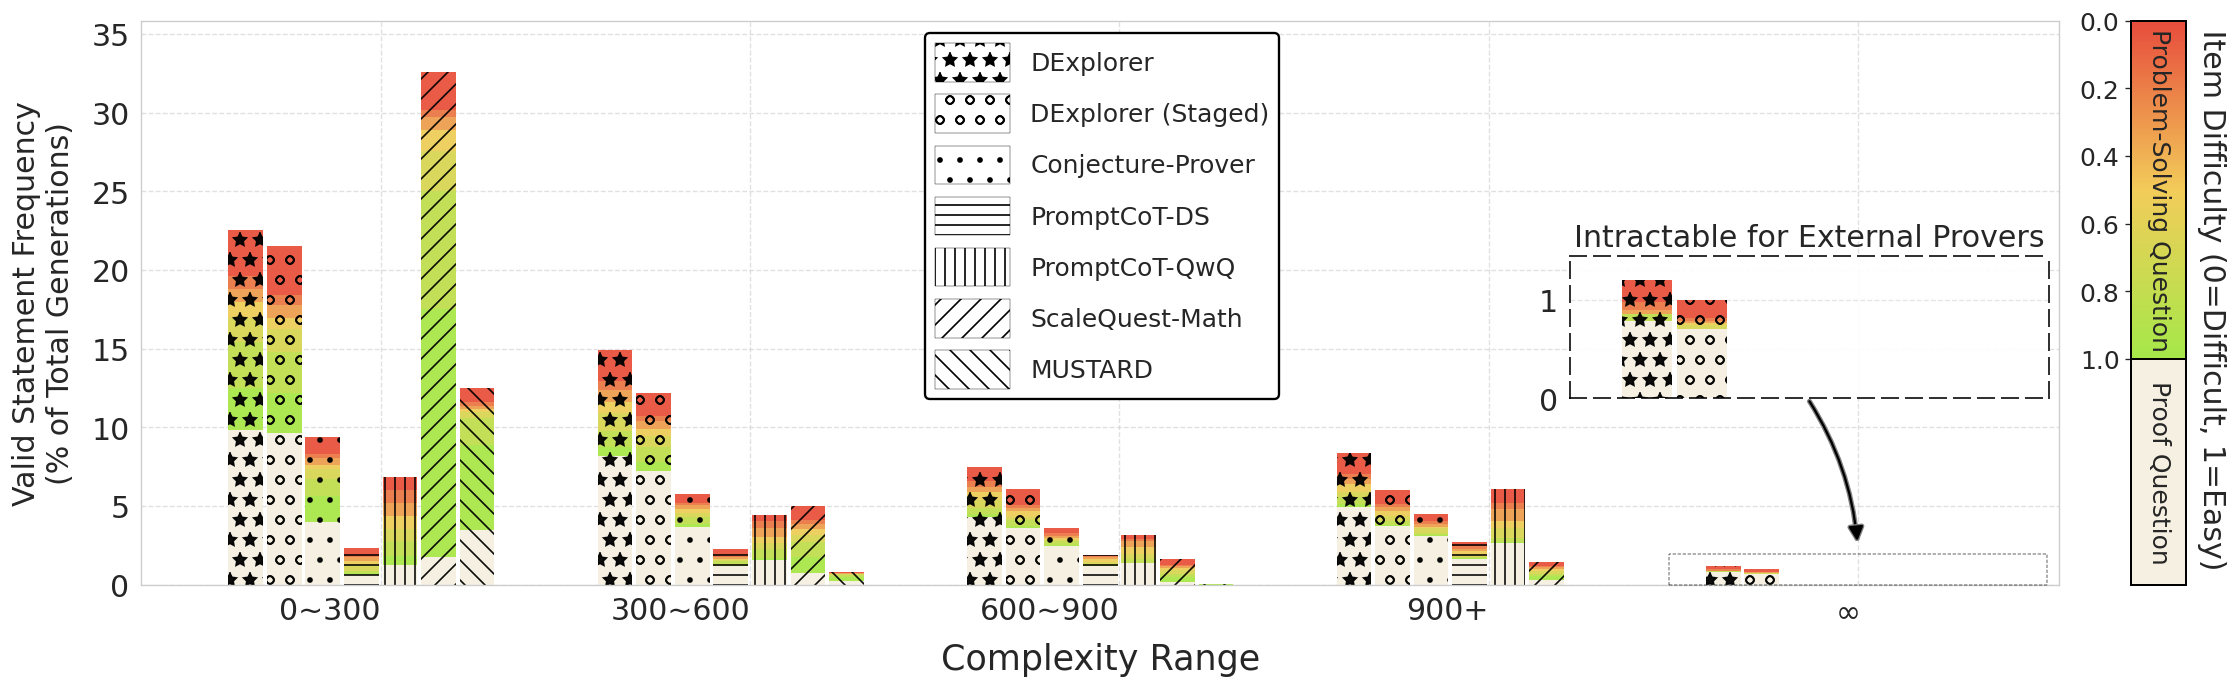

In [4]:
sns.set_style("whitegrid")

fontsize_scale = 1.5
fontsize_coeff = fontsize_scale
plt.rcParams.update({
    'font.size': 12*fontsize_coeff,         # 全局字体大小
    'axes.titlesize': 16*fontsize_coeff,    # 标题字体大小
    'axes.labelsize': 14*fontsize_coeff,    # 轴标签字体大小
    'xtick.labelsize': 12*fontsize_coeff,   # x轴刻度字体大小
    'ytick.labelsize': 12*fontsize_coeff,   # y轴刻度字体大小
    'legend.fontsize': 10*fontsize_coeff    # 图例字体大小
})
# PROOF_COLOR = (0.9, 0.9, 0.9)
# PROOF_COLOR = (0.690, 0.878, 0.902)
# PROOF_COLOR = '#B8C6CC'
# PROOF_COLOR = '#8ECAE6'
PROOF_COLOR = '#F5F0E1'

dpi = 120
figsize = (20, 6)

bins = [0, 300, 600, 900, float('inf')]
bin_labels = ['0~300', '300~600', '600~900', '900+', r'$\infty$']
num_bins = len(bin_labels)

exp_names = list(data.keys())
num_experiments = len(exp_names)

# hatches
# hatches = ['', '..', '//', '\\\\', 'xx', '++', '--', '*']
hatches = [ '*', 'o', '.', '--','||', '//', '\\\\', '++']  # 正好 7 个，分别给 7 个文件
if num_experiments > len(hatches):
    hatches = [hatches[i % len(hatches)] for i in range(num_experiments)]
else:
    hatches = hatches[:num_experiments]

# aggregations
total_counts = {exp: [0]*num_bins for exp in exp_names}
normal_difficulties = {exp: [[] for _ in range(num_bins)] for exp in exp_names}
not_evaluated_problem_counts = {exp: [0]*num_bins for exp in exp_names}

# scale factor per exp for percentage (as per your snippet: MUSTARD ~28316, others 5000)
def _delta(exp_name: str) -> float:
    return (1/28316*100) if 'mustard' in exp_name.lower() else (1/5000*100)

for exp in exp_names:
    results = data[exp]
    delta = _delta(exp)
    for complexity, difficulty, is_not_evaluated in results:
        difficulty = float(np.clip(difficulty, 0.0, 1.0))
        # choose bin
        placed = False
        for bin_idx in range(num_bins-1):
            if bins[bin_idx] <= complexity < bins[bin_idx+1]:
                total_counts[exp][bin_idx] += delta
                if is_not_evaluated:
                    not_evaluated_problem_counts[exp][bin_idx] += delta
                else:
                    normal_difficulties[exp][bin_idx].append(difficulty)
                placed = True
                break
        if not placed:
            # inf bin
            bin_idx = num_bins-1
            total_counts[exp][bin_idx] += delta
            if is_not_evaluated:
                not_evaluated_problem_counts[exp][bin_idx] += delta
            else:
                normal_difficulties[exp][bin_idx].append(difficulty)

max_count = max(max(v) for v in total_counts.values()) if total_counts else 0
bar_width = 0.95 / max(1, num_experiments)
# x = np.arange(num_bins)
group_spacing = 1.3                 # ← 组与组之间的中心距 > 1
x = np.arange(num_bins) * group_spacing

fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# colors = [
#         (0.8, 0.25, 0.25),
#         (0.95, 0.8, 0.35),
#         (0.25, 0.65, 0.25),
#     ]
colors = ["#E74C3C",  # 红色
          (0.95, 0.8, 0.35),
          "#A5E849"]  # 绿色
cmap = LinearSegmentedColormap.from_list('difficulty_cmap', colors, N=256)

for i, exp in enumerate(exp_names):
    # bar_x = x - 0.4 + bar_width/2 + i * bar_width
    bar_x = x - (bar_width * num_experiments)/2 + i * bar_width
    hatch = hatches[i]

    for bin_idx in range(num_bins):
        total_count = total_counts[exp][bin_idx]
        if total_count == 0:
            continue
        normal_count = total_count - not_evaluated_problem_counts[exp][bin_idx]
        resample_count = not_evaluated_problem_counts[exp][bin_idx]

        current_bottom = 0
        if resample_count > 0:
            ax.bar(bar_x[bin_idx], resample_count, bottom=current_bottom, width=bar_width*0.9,
                    color=PROOF_COLOR, edgecolor='black', linewidth=0.0, hatch=hatch, alpha=0.95)
            current_bottom += resample_count

        if normal_count > 0:
            diffs = normal_difficulties[exp][bin_idx]
            heatmap_bins = np.linspace(0, 1, 21)
            diff_counts, _ = np.histogram(diffs, bins=heatmap_bins)
            # scale to percentage segments
            delta = (1/28316*100) if 'mustard' in exp.lower() else (1/5000*100)
            # CHANGE 1: 先高后低绘制 → 低难度（红）最后画，出现在柱子最上层
            for h_idx in range(len(diff_counts) - 1, -1, -1):
                cnt = diff_counts[h_idx]
                if cnt == 0:
                    continue
                segment_h = cnt * delta
                difficulty_value = (heatmap_bins[h_idx] + heatmap_bins[h_idx+1]) / 2
                ax.bar(bar_x[bin_idx], segment_h, bottom=current_bottom, width=bar_width*0.9,
                    color=cmap(difficulty_value), edgecolor='black', linewidth=0.0,
                    hatch=hatch, alpha=0.95)
                current_bottom += segment_h


ax.set_xlabel('Complexity Range', fontsize=14*fontsize_scale, labelpad=10)
ax.set_ylabel('Valid Statement Frequency\n(% of Total Generations)', fontsize=12*fontsize_scale, labelpad=10)
# ax.set_title('Distribution of Generation Results by Complexity and Difficulty', fontsize=20*fontsize_scale, pad=20)
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, ha='right', fontsize=12*fontsize_scale)
if max_count:
    ax.set_ylim(0, max_count * 1.1)
ax.grid(axis='both', linestyle='--', alpha=0.6)




legend_elements = [plt.Rectangle((0,0),1,1, facecolor='white',
                                    edgecolor='black', hatch=hatches[i], linewidth=0.25) 
                    for i, _ in enumerate(exp_names)]

leg = ax.legend(
    legend_elements, exp_names,
    loc='upper right',
    bbox_to_anchor=(0.6, 1.0),
    # title='Experiments',
    title='',
    fontsize=10*fontsize_scale, title_fontsize=12*fontsize_scale,
    handlelength=3.0,
    handleheight=2.0,
    frameon=True,           # ← 打开外框
)


# 设置外框线条更粗、更明显
frame = leg.get_frame()
frame.set_linewidth(1.4)    # ← 粗细（默认 0.8）
frame.set_edgecolor('black')
frame.set_alpha(1.0)



# ---------- Inset: 放大最后一组（∞ 组） ----------
last_bin_idx = num_bins - 1
center = x[last_bin_idx]
group_halfwidth = (bar_width * num_experiments) / 2.0


# 在右上角放一个 inset（相对坐标位置+大小可微调）
axins = inset_axes(
    ax,
    width="25%", height="42%",
    loc="upper right",
    bbox_to_anchor=(0, 0, 1, 0.6),   # ← 原来是 (0,0,1,1)，把高度改成 0.92
    bbox_transform=ax.transAxes,
    borderpad=0.4
)
axins.set_zorder(7)  # 保证压在柱子和虚线框之上
# 让 inset 的边框变成虚线
# 提高 inset 视觉对比（可选：给一点浅白底，减少内部网格干扰）
axins.set_facecolor((1, 1, 1, 0.92))  # 想完全透明可注释掉

# 让 inset 的边框“更粗+更明显的虚线+白描边”
for spine in axins.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)         # 和下面 Rectangle 一样粗
    spine.set_linestyle((0, (8, 4)))  # ← 8pt 实线 + 4pt 空白，虚线更“稀疏”
    spine.set_alpha(0.8)              # 和下面 Rectangle 一样透明度
    

# 只重画最后一组的柱子（和主图一致的配色/纹理/边框）
for i, exp in enumerate(exp_names):
    bar_x = center - (bar_width * num_experiments)/2 + i * bar_width
    hatch = hatches[i]

    total_count = total_counts[exp][last_bin_idx]
    if total_count == 0:
        continue
    normal_count = total_count - not_evaluated_problem_counts[exp][last_bin_idx]
    resample_count = not_evaluated_problem_counts[exp][last_bin_idx]

    current_bottom = 0.0
    if resample_count > 0:
        axins.bar(bar_x, resample_count, bottom=current_bottom, width=bar_width*0.9,
                color=PROOF_COLOR, edgecolor='black', linewidth=0.0, hatch=hatch, alpha=0.95)
        current_bottom += resample_count

    if normal_count > 0:
        diffs = normal_difficulties[exp][last_bin_idx]
        heatmap_bins = np.linspace(0, 1, 21)
        diff_counts, _ = np.histogram(diffs, bins=heatmap_bins)
        delta = (1/28316*100) if 'mustard' in exp.lower() else (1/5000*100)
        # CHANGE 2: inset 也改为先高后低
        for h_idx in range(len(diff_counts) - 1, -1, -1):
            cnt = diff_counts[h_idx]
            if cnt == 0:
                continue
            segment_h = cnt * delta
            difficulty_value = (heatmap_bins[h_idx] + heatmap_bins[h_idx+1]) / 2
            axins.bar(bar_x, segment_h, bottom=current_bottom, width=bar_width*0.9,
                    color=cmap(difficulty_value), edgecolor='black', linewidth=0.0,
                    hatch=hatch, alpha=0.95)
            current_bottom += segment_h


# 只框定最后一组的横向范围，让“放大”更明显
# 只框定最后一组的横向范围，让“放大”更明显，并额外给左侧留白
margin = bar_width * 0.3
left  = center - group_halfwidth - margin
right = center + group_halfwidth + margin

pad_left = bar_width * 1.1   # ← 左侧额外留白的宽度（可调 0.8~1.5）
axins.set_xlim(left - pad_left, right)

# 纵轴范围按该组的最大高度设置
ymax_group = max(total_counts[exp][last_bin_idx] for exp in exp_names) if exp_names else 0
axins.set_ylim(0, ymax_group * 1.2)

# 美化 inset：去掉 x 刻度，保留细虚线 y 网格
axins.set_xticks([])
axins.grid(axis='y', linestyle='--', alpha=0.5)
axins.set_title('Intractable for External Provers', fontsize=12*fontsize_scale, pad=6)


    # ---- 在主图上框出 ∞ 组 ----（先画框）
last_bin_idx = num_bins - 1
center = x[last_bin_idx]
group_halfwidth = (bar_width * num_experiments) / 2.0

ymax_group = max(total_counts[exp][last_bin_idx] for exp in exp_names) if exp_names else 0

expand_x = group_halfwidth * 1.4
expand_y = ymax_group * 1.6

rect = Rectangle(
    (center - expand_x, 0),
    width=expand_x * 2,
    height=expand_y,
    linewidth=0.25, edgecolor='black', facecolor='none',
    linestyle=(0, (8, 4)), alpha=0.8, zorder=4
)
rect.set_clip_on(False)
ax.add_patch(rect)

# --- 指向 ∞ 组：连线 + 文字 ---（后画箭头）
# 箭头终点对齐虚线框顶部，避免指到框里
y_target = rect.get_bbox().ymax

cp = ConnectionPatch(
    # 起点：inset 底边中点（稍微在外侧，避免压到虚线边框）
    xyA=(0.50, -0.02), coordsA=axins.transAxes,   # ← 原来是 (1.01, 0.45)

    # 终点：主图虚线框顶边
    xyB=(center, y_target), coordsB=ax.transData,

    arrowstyle="-|>",
    mutation_scale=18,
    connectionstyle="arc3,rad=-0.13",   # 可微调弧度，负值让弧线向右拱
    lw=1.4, color="black",

    # 起点就在框外，A 端不再收缩；B 端略缩让箭头停在框边
    shrinkA=0,                           # ← 原来 12
    shrinkB=8                            # 保持或微调
)
cp.set_clip_on(False)
cp.set_zorder(20)
cp.set_path_effects([pe.Stroke(linewidth=3.0, foreground="gray"), pe.Normal()])
ax.add_artist(cp)

ax.text(center, y_target, "", ha="left", va="bottom",
        fontsize=11*fontsize_scale, color="black", zorder=9)
rect.set_clip_on(False)
ax.add_patch(rect)




# ---- 画完主图、legend、inset ----
fig = plt.gcf()
fig.tight_layout(rect=[0, 0, 0.88, 1])  # 右侧预留 4% 给色条

# 主轴最终位置（figure 坐标）
box = ax.get_position()

# ---- 计算色条与 Proof 空白区的位置 ----
pad   = 0.03           # 主轴与色条水平间距（figure 坐标）
width = 0.023           # 色条宽度（figure 坐标）

# Proof 空白区：紧贴主轴底边，与横轴齐平；高度=主轴高度的 1/4
proof_y0 = box.y0 - box.height * 0.0
proof_h  = box.height * 0.4

# 渐变色条：放在上 3/4
x0 = box.x1 + pad
y0 = proof_y0 + proof_h           # 色条底边 = 空白区顶边
h  = box.height * 0.6            # 色条高度 = 上 3/4

# ---- 创建色条轴（只占上 3/4）并绘制 ----
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

cax  = fig.add_axes([x0, y0, width, h])
sm   = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('                       Item Difficulty (0=Difficult, 1=Easy)', rotation=270, labelpad=24, fontsize=12*fontsize_scale)
cbar.ax.tick_params(labelsize=10*fontsize_scale)
cbar.ax.invert_yaxis()   # 红在上
cbar.ax.yaxis.set_ticks_position('left')

# label = cbar.get_label()  # 获取标签对象
# # 获取当前位置，调整y值（减小y值实现向下平移，数值根据需要调整）
# current_pos = label.get_position()
# new_pos = (current_pos[0], current_pos[1] - 0.1)  # 减小y值，负数越大向下移动越多
# label.set_position(new_pos)

# 1) 整根色条区域外框（覆盖渐变 + 空白区）
for spine in cax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

# 2) 在渐变与空白的交界处画分界线（正好是色条底边）
fig.add_artist(
    mlines.Line2D([x0, x0 + width], [y0, y0],
                transform=fig.transFigure, color='black', linewidth=1.2)
)

# 3) 给 Proof 空白区画外框（保证白底也有清晰边界）
fig.add_artist(
    mpatches.Rectangle(
        (x0, proof_y0), width, proof_h,
        transform=fig.transFigure, facecolor=PROOF_COLOR,
        edgecolor='black', linewidth=1.2,
    )
)

# 4) 文案：放在各自区域的中心
fig.text(x0 + width/2, proof_y0 + proof_h/2, 'Proof Question',
        ha='center', va='center', rotation=270, fontsize=10*fontsize_scale,
        transform=fig.transFigure)

fig.text(x0 + width/2, y0 + h/2, 'Problem-Solving Question',
        ha='center', va='center', rotation=270, fontsize=10*fontsize_scale,
        transform=fig.transFigure)
    
# plt.show()
PROOF_COLOR
plt.savefig('fig1.pdf')

In [5]:
cbar.ax.get_label()

''